<a href="https://colab.research.google.com/github/vadim-privalov/Neiroset_Novosibirsk/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22Lesson_33_keras_fire_detection_ENG%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Обнаружение огня и дыма с помощью Keras и глубокого обучения

# Fire and smoke detection with Keras and deep learning

В этом уроке вы узнаете, как обнаруживать огонь и дым с помощью компьютерного зрения, OpenCV и библиотек Keras Deep Learning.

In this tutorial, you will learn how to detect fire and smoke using computer vision, OpenCV, and Keras Deep Learning libraries.

Компьютерное зрение и глубокое обучение можно использовать для обнаружения лесных пожаров:

Computer vision and deep learning can be used to detect forest fires:

* Устройства IoT / Edge, оснащенные камерами, можно установить на склонах холмов, хребтов и возвышенностей, автоматически отслеживать признаки дыма или огня. IoT / Edge devices equipped with cameras can be installed on hillsides, ridges and elevations, automatically monitor for signs of smoke or fire.
* Дроны и квадрокоптеры могут летать над зонами, подверженными лесным пожарам, и сканировать их на наличие дыма. Drones and quadcopters can fly over areas prone to forest fires and scan them for smoke.
* Спутники можно использовать для фотографирования больших площадей, в то время как алгоритмы компьютерного зрения и глубокого обучения обрабатывают эти изображения в поисках следов дыма. Satellites can be used to photograph large areas, while computer vision and deep learning algorithms process these images in search of smoke marks.



### Загрузка файлов
### Download the code zip file

In [1]:
!wget http://dataudt.ru/datasets/cv/Lesson_33.keras_fire_detection.zip
!unzip -qq Lesson_33.keras_fire_detection.zip
%cd /content/Lesson_33.keras_fire_detection/

--2022-02-19 10:55:35--  http://dataudt.ru/datasets/cv/Lesson_33.keras_fire_detection.zip
Resolving dataudt.ru (dataudt.ru)... 37.228.117.130
Connecting to dataudt.ru (dataudt.ru)|37.228.117.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 615839953 (587M) [application/zip]
Saving to: ‘Lesson_33.keras_fire_detection.zip’

Lesson_33.keras_fir 100%[===================>] 587.31M  21.2MB/s    in 29s     

2022-02-19 10:56:04 (20.5 MB/s) - ‘Lesson_33.keras_fire_detection.zip’ saved [615839953/615839953]

/content/Lesson_33.keras_fire_detection


### Загрузка датасета
### Downloading the dataset

Для обучения нашей модели нам понадобится 2 датасета: картинки с огнем и без огня.

To train our model, we need 2 datasets: pictures with and without fire.

В качестве изображений без огня используем [датасет с 8 сценами](https://people.csail.mit.edu/torralba/code/spatialenvelope/)

For images without fire, we use [dataset with 8 scenes](https://people.csail.mit.edu/torralba/code/spatialenvelope/)

In [2]:
!wget https://pis-datasets.s3.us-east-2.amazonaws.com/spatial_envelope_256x256_static_8outdoorcategories.zip
!unzip -qq spatial_envelope_256x256_static_8outdoorcategories.zip

--2022-02-19 10:57:27--  https://pis-datasets.s3.us-east-2.amazonaws.com/spatial_envelope_256x256_static_8outdoorcategories.zip
Resolving pis-datasets.s3.us-east-2.amazonaws.com (pis-datasets.s3.us-east-2.amazonaws.com)... 52.219.107.58
Connecting to pis-datasets.s3.us-east-2.amazonaws.com (pis-datasets.s3.us-east-2.amazonaws.com)|52.219.107.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 135033638 (129M) [application/zip]
Saving to: ‘spatial_envelope_256x256_static_8outdoorcategories.zip’

spatial_envelope_25 100%[===================>] 128.78M  87.0MB/s    in 1.5s    

2022-02-19 10:57:29 (87.0 MB/s) - ‘spatial_envelope_256x256_static_8outdoorcategories.zip’ saved [135033638/135033638]



### Импорт библиотек
### Import Packages

In [3]:
# импортируем необходимые библиотеки
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from pred_fire.learningratefinder import LearningRateFinder
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import imutils
import random
import cv2
import sys
import os

### Функция отображения изображений в Jupyter Notebooks и Google Colab 
### Function to display images in Jupyter Notebooks and Google Colab

In [4]:
def plt_imshow(title, image):
    # конвертируем изображение из формата BGR в RGB и отображаем его 
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.figure(figsize=(10, 10))
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### Файл конфигурации
### Our configuration file

In [5]:
class Config:
    # инициализируем путь к датасету изображений с огнем и без
    # initialize the path to the fire and non-fire dataset directories
    FIRE_PATH = "fire_dataset"
    NON_FIRE_PATH = "spatial_envelope_256x256_static_8outdoorcategories"
    
    # инициализируем метки классов в датасете
    # initialize the class labels in the dataset
    CLASSES = ["Non-Fire", "Fire"]

    # определяем размер обучающей и тестовой выборки
    # define the size of the training and testing split
    TRAIN_SPLIT = 0.75
    TEST_SPLIT = 0.25
    
    # определяем начальную скорость обучения, размер батча и количество эпох
    # define the initial learning rate, batch size, and number of epochs
    INIT_LR = 1e-2
    BATCH_SIZE = 64
    NUM_EPOCHS = 50

    # задаем путь к сохраненной модели после обучения
    # set the path to the serialized model after training
    MODEL_PATH = os.path.sep.join(["output", "fire_detection.model"])
    
    # определяем путь к выходным графикам поисковика скорости обучения и
    # истории обучения
    # define the path to the output learning rate finder plot and
    # training history plot
    LRFIND_PLOT_PATH = os.path.sep.join(["output", "lrfind_plot.png"])
    TRAINING_PLOT_PATH = os.path.sep.join(["output", "training_plot.png"])

    # определяем путь к выходному каталогу, в котором будет храниться наш финальный
    # выходной файл с метками / комментариями вместе с количеством изображений для
    # образеца
    # define the path to the output directory that will store our final
    # output with labels/annotations along with the number of images to
    # sample
    OUTPUT_IMAGE_PATH = os.path.sep.join(["output", "examples"])
    SAMPLE_SIZE = 50

# создаем объект класса конфигурации
# initialize the configuration object
config = Config()

### Implementing our fire detection Convolutional Neural Network

### Реализация нашей конволюционной нейронной сети для обнаружения пожара


In [6]:
class FireDetectionNet:
	@staticmethod
	def build(width, height, depth, classes):
        # инициализируем модель вместе с входными размерами как
		# "последние каналы" и самой размерностью каналов
		# initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1

        # свертка => функция активации RELU => пулинг
		# CONV => RELU => POOL
		model.add(SeparableConv2D(16, (7, 7), padding="same",
			input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))

        # свертка => функция активации RELU => пулинг
		# CONV => RELU => POOL
		model.add(SeparableConv2D(32, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))

        # (свертка => функция активации RELU) * 2 => пулинг
		# (CONV => RELU) * 2 => POOL
		model.add(SeparableConv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(SeparableConv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))

        # первый слой FC => слои RELU
		# first set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(128))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

        # второй слой FC => слои RELU
		# second set of FC => RELU layers
		model.add(Dense(128))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

        # softmax классификатор
		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))

        # возвращаем построенную архитектуру сети
		# return the constructed network architecture
		return model

### Создаем код обучения
### Creating our training script

In [7]:
def load_dataset(datasetPath):
    # получаем пути ко всем изображениям в каталоге нашего набора данных, затем
	# инициализируем наши списки изображений
	# grab the paths to all images in our dataset directory, then
	# initialize our lists of images
	imagePaths = list(paths.list_images(datasetPath))
	data = []

    # перебираем пути к изображениям
	# loop over the image paths
	for imagePath in imagePaths:
        # загружаем изображение и изменяем его размер до фиксированных 128x128 пикселей,
		# игнорируя соотношения сторон
		# load the image and resize it to be a fixed 128x128 pixels,
		# ignoring aspect ratio
		image = cv2.imread(imagePath)
		image = cv2.resize(image, (128, 128))

        # добавляем изображение в списки данных
		# add the image to the data lists
		data.append(image)

    # возвращаем список данных как массив NumPy
	# return the data list as a NumPy array
	return np.array(data, dtype="float32")

In [8]:

# явно укажем аргументы необходимые для работы
# lr_find - искать или нет оптимальную скорость обучения

# explicitly specify the arguments needed to work
# lr_find - whether or not to find optimal learning rate
args = {
   "lr_find": 0
}

In [9]:
# загружаем изображения с огнем и без огня
# load the fire and non-fire images
print("[INFO] loading data...")
fireData = load_dataset(config.FIRE_PATH)
nonFireData = load_dataset(config.NON_FIRE_PATH)

# создаем метки классов для данных
# construct the class labels for the data
fireLabels = np.ones((fireData.shape[0],))
nonFireLabels = np.zeros((nonFireData.shape[0],))

# совмещаем данные о пожаре с данными без пожара, затем нормируем данные
# в диапазоне [0, 1]
# stack the fire data with the non-fire data, then scale the data
# to the range [0, 1]
data = np.vstack([fireData, nonFireData])
labels = np.hstack([fireLabels, nonFireLabels])
data /= 255

[INFO] loading data...


In [10]:
# выполняем one-hot кодирование меток и учитываем дисбаланс в
# помеченных данных
# perform one-hot encoding on the labels and account for skew in the
# labeled data
labels = to_categorical(labels, num_classes=2)

# вычисляем общее количество изображений в каждом классе и
# инициализируем словарь для хранения весов 
# calculate the total number of images in each class and
# initialize a dictionary to store the class weights
classTotals = labels.sum(axis=0)
classWeight = dict()

# перебираем все классы и вычисляем их веса
# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
	classWeight[i] = classTotals.max() / classTotals[i]


# разделим данные на обучающую и тестовую выборку
# construct the training and testing split
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=config.TEST_SPLIT, random_state=42)

In [11]:
# создадим аугментации обучающих данных
# initialize the training data augmentation object
aug = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# инициализируем оптимизатор и модель
# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(lr=config.INIT_LR, momentum=0.9,
	decay=config.INIT_LR / config.NUM_EPOCHS)
model = FireDetectionNet.build(width=128, height=128, depth=3,
	classes=2)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [12]:
# проверяем, есть ли у нас оптимальная скорость обучения
# перед обучением на все количество эпох
# check to see if we are attempting to find an optimal learning rate
# before training for the full number of epochs
if args["lr_find"] > 0:
    # инициализируем поисковик скорости обучения, а затем тренируем модель со скоростью
	# обучения от 1e-10 до 1e + 1
	# initialize the learning rate finder and then train with learning
	# rates ranging from 1e-10 to 1e+1
	print("[INFO] finding learning rate...")
	lrf = LearningRateFinder(model)
	lrf.find(
		aug.flow(trainX, trainY, batch_size=config.BATCH_SIZE),
		1e-10, 1e+1,
		stepsPerEpoch=np.ceil((trainX.shape[0] / float(config.BATCH_SIZE))),
		epochs=20,
		batchSize=config.BATCH_SIZE,
		classWeight=classWeight)

    # построим график функий потерь для различных скоростей обучения и сохраняем
	# полученный график на диск
	# plot the loss for the various learning rates and save the
	# resulting plot to disk
	lrf.plot_loss()
	plt.savefig(config.LRFIND_PLOT_PATH)

    # выходим из скрипта, чтобы мы могли скорректировать скорость обучения
	# в конфигурации, а затем обучить сеть по нашему полному набору эпох
	# gracefully exit the script so we can adjust our learning rates
	# in the config and then train the network for our full set of
	# epochs
	print("[INFO] learning rate finder complete")
	print("[INFO] examine plot and adjust learning rates before training")

In [13]:
# обучаем сеть
# train the network
print("[INFO] training network...")
H = model.fit_generator(
	aug.flow(trainX, trainY, batch_size=config.BATCH_SIZE),
	validation_data=(testX, testY),
	steps_per_epoch=trainX.shape[0] // config.BATCH_SIZE,
	epochs=config.NUM_EPOCHS,
	class_weight=classWeight,
	verbose=1)

[INFO] training network...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/50
85/85 [==============================] - 202s 2s/step - loss: 0.6072 - accuracy: 0.8009 - val_loss: 0.5515 - val_accuracy: 0.6536
Epoch 2/50
85/85 [==============================] - 201s 2s/step - loss: 0.4686 - accuracy: 0.8365 - val_loss: 0.4658 - val_accuracy: 0.8060
Epoch 3/50
85/85 [==============================] - 202s 2s/step - loss: 0.4173 - accuracy: 0.8570 - val_loss: 0.3566 - val_accuracy: 0.8525
Epoch 4/50
85/85 [==============================] - 201s 2s/step - loss: 0.3886 - accuracy: 0.8647 - val_loss: 0.3134 - val_accuracy: 0.8787
Epoch 5/50
85/85 [==============================] - 204s 2s/step - loss: 0.4007 - accuracy: 0.8627 - val_loss: 0.2777 - val_accuracy: 0.8754
Epoch 6/50
85/85 [==============================] - 206s 2s/step - loss: 0.3843 - accuracy: 0.8673 - val_loss: 0.2363 - val_accuracy: 0.8940
Epoch 7/50
85/85 [==============================] - 204s 2s/step - loss: 0.3627 - accuracy: 0.8750 - val_loss: 0.2304 - val_accuracy: 0.8989
Epoch 8/50
85

Сохраняем модель

Save the model

In [14]:
model.save('model.h5')

При желании можно загрузить уже обученную модель, чтобы не обучать ее повторно.


You can load an already trained model so as not to train it again.

In [ ]:
#from tensorflow.keras.models import load_model
#model = load_model('model.h5')

[INFO] evaluating network...
              precision    recall  f1-score   support

    Non-Fire       0.89      0.94      0.91       642
        Fire       0.97      0.93      0.95      1188

    accuracy                           0.94      1830
   macro avg       0.93      0.94      0.93      1830
weighted avg       0.94      0.94      0.94      1830

[INFO] serializing network to 'output/fire_detection.model'...
INFO:tensorflow:Assets written to: output/fire_detection.model/assets


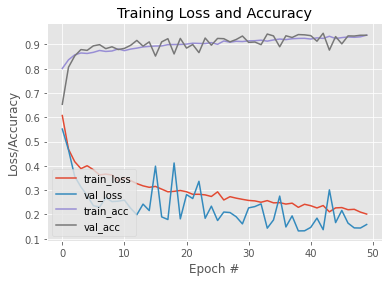

In [15]:
# оцениваем сеть и показываем отчет о классификации
# evaluate the network and show a classification report
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=config.BATCH_SIZE)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=config.CLASSES))

# сохраняем модель на диск
# serialize the model to disk
print("[INFO] serializing network to '{}'...".format(config.MODEL_PATH))
model.save(config.MODEL_PATH)

# строим график, который отображает и сохраняет историю обучения
# construct a plot that plots and saves the training history
N = np.arange(0, config.NUM_EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(config.TRAINING_PLOT_PATH)

### Прогнозирование изображений с огнем/без

### Making predictions on fire/non-fire images

In [17]:
# загружаем обученную модель с диска
# load the trained model from disk
print("[INFO] loading model...")
model = load_model(config.MODEL_PATH)

[INFO] loading model...


NameError: ignored

In [18]:
# найдем пути к изображениям с огнем и без соответственно
# grab the paths to the fire and non-fire images, respectively
print("[INFO] predicting...")
firePaths = list(paths.list_images(config.FIRE_PATH))
nonFirePaths = list(paths.list_images(config.NON_FIRE_PATH))

# объединяем два списка путей к изображениям, случайным образом перемешиваем и выбираем их
# combine the two image path lists, randomly shuffle them, and sample
# them
imagePaths = firePaths + nonFirePaths
random.shuffle(imagePaths)
imagePaths = imagePaths[:config.SAMPLE_SIZE]

[INFO] predicting...


In [19]:
# перебираем пути к выбранным изображениям
# loop over the sampled image paths
for (i, imagePath) in enumerate(imagePaths):
    # загружаем изображение и копируем его
	# load the image and clone it
	image = cv2.imread(imagePath)
	output = image.copy()

    # загружаем изображение и изменяем его размер до фиксированных 128x128 пикселей,
	# игнорируя соотношения сторон
	# resize the input image to be a fixed 128x128 pixels, ignoring
	# aspect ratio
	image = cv2.resize(image, (128, 128))
	image = image.astype("float32") / 255.0
		
    # делаем предсказание по изображению
	# make predictions on the image
	preds = model.predict(np.expand_dims(image, axis=0))[0]
	j = np.argmax(preds)
	label = config.CLASSES[j]

    # рисуем надпись в выходном изображении
	# draw the activity on the output frame
	text = label if label == "Non-Fire" else "WARNING! Fire!"
	output = imutils.resize(output, width=500)
	cv2.putText(output, text, (35, 50), cv2.FONT_HERSHEY_SIMPLEX,
		1.25, (0, 255, 0), 5)

    # записываем выходное изображение на диск
	# write the output image to disk	 
	filename = "{}.png".format(i)
	p = os.path.sep.join([config.OUTPUT_IMAGE_PATH, filename])
	cv2.imwrite(p, output)

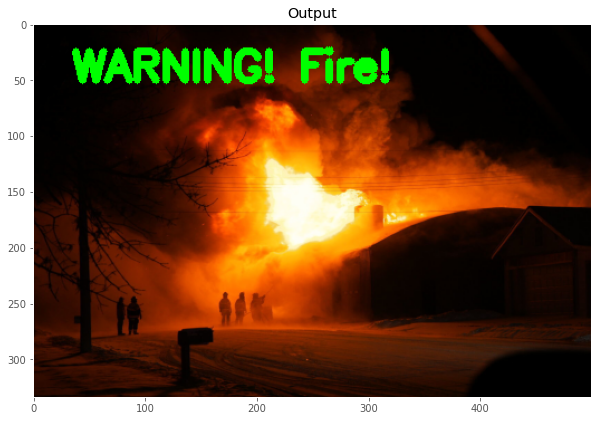

In [20]:
plt_imshow("Output", output)